## SVM - MNIST - Digit Recognizer - Kaggle 
> ### ***Submission by - Srinivasan Gopalakrishnan***
> ### ***Submitted on  - 15, April, 2019***
> ### ***Student Batch - PGDDS September 2018***

### Problem Statement
> The problem involves the classic case of Handwritten digit recognition. The digits ranging from 0 through 9 written by various people are captured as images of specific size. The aim is to develop a model which can correctly identify the digits (0 through 9) written randomly on an image.

### Goal
>- Develop a Support Vector Machine Model which should able to classify the handwritten images digits from 0 through 9 based on the data ,plixel values for each image given as features. 

### Data Structure
>- The pixel values of each digits image are provided as features and actual representing number 0  through 9 as a label name of the digit.<br>
>- Since the image size 28 x 28 pixel, there are 784 features each representing the pixel value indicating the lightness or darkness of the pixel (higher the number more darker the pixel).<br>
>- Thus training data set has 785 columns - first column being label name (digit drawn by the user) and reset of the 784 columns representing the pixel values representing the image on each row.<br>
>- The test data set is similar to training data set but without label name column.<br>

## Step 1: Import Libraries

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing all required packages
import math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Scikit Libraries.
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# Evaluate the model
from sklearn import metrics
from sklearn.metrics import classification_report

#Cross validations  libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

In [3]:
# Set up jupyter notebook options 
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Setup few jupyter notebook display options.
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",400)

## Step 2: Reading and Understanding MNIST the Data

In [4]:
# Read the mnist train data  
mnist_train = pd.read_csv("./train.csv")
mnist_train.shape

(42000, 785)

In [5]:
mnist_test = pd.read_csv("./test.csv")
mnist_test.shape

(28000, 784)

In [79]:
mnist_train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [6]:
mnist_test.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

#### **Observations**<br>
>- There are `42000` rows and `785` columns in train set.
>- There are `28000` rows and `784` columns in test set.
 
#### **Inference**<br>
>- For Model Building and testing we will use Train data set.
>- We will validate using the Test Data once model built and finalized using train set.
>- Next step to investigate the data and prepare the data for analysis.

## Step 3: Data Understaind and Preparation

###  3.1 :  Verify the rows in data sets where all columns have null values  

In [7]:
# Create a train_df only with pixel features.
train_label_df = pd.DataFrame(mnist_train['label'])
mnist_train = mnist_train.drop('label',1)

In [8]:
# Check Train set has null values.
print(mnist_train.isnull().all(axis=0).sum())

# Check Test Set has null values 
print(mnist_test.isnull().all(axis=0).sum())

0
0


###  3.3 :  Check in data sets any columns have null values  

In [9]:
# Check any NAs in the Train Data Set 
NaN_cols1 =mnist_train.columns[mnist_train.isnull().any()]
print(NaN_cols1)

# Check any NAs in the Test Data Set 
NaN_cols2 =mnist_test.columns[mnist_test.isnull().any()]
print(NaN_cols2)

Index([], dtype='object')
Index([], dtype='object')


#### 3.4 :  Verify values of columns in range 0 to 255.  

In [10]:
# Verify train any value greater than 255  
print(mnist_train[(mnist_train < 0) | (mnist_train > 255)].any().sum())

# Verify test any value greater than 255 
print(mnist_test[(mnist_test < 0) | (mnist_test > 255)].any().sum())

0
0


In [11]:
# Verify the label column is in range.
print(train_label_df.label.value_counts())

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


#### **Observations**<br>
>- Verified for any rows having all columns have NaN (Null) Values for both train and test sets and found there isn't any rows present having all columns as Null.
>- Verified for any columns in the training and test data frames for NaN Values. There is no null values present in the both set.
>- Check columns having values for train and test exceed 255 (as pixel values only within the range of 0 to 255).

#### **Inference**<br>
>-  Merge the Label column back to the train data set for further analysis.

In [12]:
# merge the label column to final train data set.
train = pd.concat([train_label_df,mnist_train],axis=1)
test = mnist_test.copy()

# Verify the shape of final data frame.
train.shape
test.shape

(42000, 785)

(28000, 784)

#### **Observation**<br>

>- The final cleaned up train and test available for Model Building and Testing.
>- Since, the training data set is large as we have `42000` rows it will take lot of time for taining SVM on the full MNIST So we can sub sample the data of approximately `20%` for training to achive the decent accuracy.
> - Also, cross validation may take long hours , it is wiser to take 20% of the train and test data.

### 3.6 :  Take Sample 50% of Training and full Test (for predictions) Data for our Model

In [13]:
train = train.sample(frac=0.50,random_state=1)
#test = test.sample(frac=0.50,random_state=1)

In [14]:
train.shape
test.shape
train.head()
test.head()

(21000, 785)

(28000, 784)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,...,pixel584,pixel585,pixel586,pixel587,pixel588,pixel589,pixel590,pixel591,pixel592,pixel593,pixel594,pixel595,pixel596,pixel597,pixel598,pixel599,pixel600,pixel601,pixel602,pixel603,pixel604,pixel605,pixel606,pixel607,pixel608,pixel609,pixel610,pixel611,pixel612,pixel613,pixel614,pixel615,pixel616,pixel617,pixel618,pixel619,pixel620,pixel621,pixel622,pixel623,pixel624,pixel625,pixel626,pixel627,pixel628,pixel629,pixel630,pixel631,pixel632,pixel633,pixel634,pixel635,pixel636,pixel637,pixel638,pixel639,pixel640,pixel641,pixel642,pixel643,pixel644,pixel645,pixel646,pixel647,pixel648,pixel649,pixel650,pixel651,pixel652,pixel653,pixel654,pixel655,pixel656,pixel657,pixel658,pixel659,pixel660,pixel661,pixel662,pixel663,pixel664,pixel665,pixel666,pixel667,pixel668,pixel669,pixel670,pixel671,pixel672,pixel673,pixel674,pixel675,pixel676,pixel677,pixel678,pixel679,pixel680,pixel681,pixel682,pixel683,pixel684,pixel685,pixel686,pixel687,pixel688,pixel689,pixel690,pixel691,pixel692,pixel693,pixel694,pixel695,pixel696,pixel697,pixel698,pixel699,pixel700,pixel701,pixel702,pixel703,pixel704,pixel705,pixel706,pixel707,pixel708,pixel709,pixel710,pixel711,pixel712,pixel713,pixel714,pixel715,pixel716,pixel717,pixel718,pixel719,pixel720,pixel721,pixel722,pixel723,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
29633,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,97,254,235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,251,253,234,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,112,253,253,246,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,...,pixel584,pixel585,pixel586,pixel587,pixel588,pixel589,pixel590,pixel591,pixel592,pixel593,pixel594,pixel595,pixel596,pixel597,pixel598,pixel599,pixel600,pixel601,pixel602,pixel603,pixel604,pixel605,pixel606,pixel607,pixel608,pixel609,pixel610,pixel611,pixel612,pixel613,pixel614,pixel615,pixel616,pixel617,pixel618,pixel619,pixel620,pixel621,pixel622,pixel623,pixel624,pixel625,pixel626,pixel627,pixel628,pixel629,pixel630,pixel631,pixel632,pixel633,pixel634,pixel635,pixel636,pixel637,pixel638,pixel639,pixel640,pixel641,pixel642,pixel643,pixel644,pixel645,pixel646,pixel647,pixel648,pixel649,pixel650,pixel651,pixel652,pixel653,pixel654,pixel655,pixel656,pixel657,pixel658,pixel659,pixel660,pixel661,pixel662,pixel663,pixel664,pixel665,pixel666,pixel667,pixel668,pixel669,pixel670,pixel671,pixel672,pixel673,pixel674,pixel675,pixel676,pixel677,pixel678,pixel679,pixel680,pixel681,pixel682,pixel683,pixel684,pixel685,pixel686,pixel687,pixel688,pixel689,pixel690,pixel691,pixel692,pixel693,pixel694,pixel695,pixel696,pixel697,pixel698,pixel699,pixel700,pixel701,pixel702,pixel703,pixel704,pixel705,pixel706,pixel707,pixel708,pixel709,pixel710,pixel711,pixel712,pixel713,pixel714,pixel715,pixel716,pixel717,pixel718,pixel719,pixel720,pixel721,pixel722,pixel723,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,17,17,17,17,81,180,180,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,139,253,253,253,253,253,253,253,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,228,253,253,253,253,253,253,253,207,197,46,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,26,179,179,179,179,179,30,15,10

### 3.6 :  Plot the Distributions of digits across train set.

In [15]:
# Use Seaborn for plots.
sns.set()
sns.set(style="whitegrid",palette='muted',color_codes=True)

In [16]:
# Generate label train data frame to plot.
df_train_label = pd.DataFrame(train.groupby('label')['label'].count())
df_train_label.columns = ['counts']
df_train_label = df_train_label.reset_index()
order = list(np.sort(df_train_label['label'].unique()))

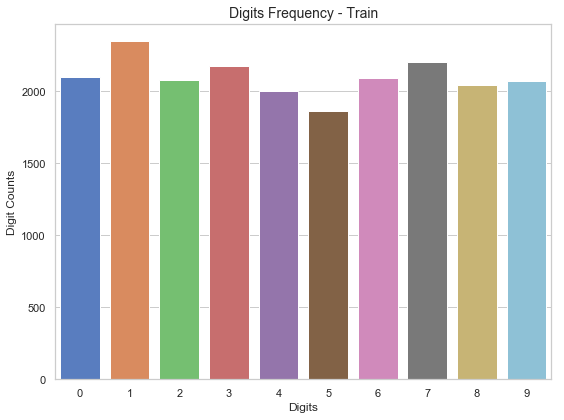

In [17]:
# plot the frequencies of labels.
plt.figure(figsize=(8, 6))
sns.countplot(x='label',data=train)
plt.xlabel("Digits")
plt.ylabel("Digit Counts")
plt.title("Digits Frequency - Train",fontsize=14)
plt.tight_layout()
plt.show();

In [18]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,...,pixel584,pixel585,pixel586,pixel587,pixel588,pixel589,pixel590,pixel591,pixel592,pixel593,pixel594,pixel595,pixel596,pixel597,pixel598,pixel599,pixel600,pixel601,pixel602,pixel603,pixel604,pixel605,pixel606,pixel607,pixel608,pixel609,pixel610,pixel611,pixel612,pixel613,pixel614,pixel615,pixel616,pixel617,pixel618,pixel619,pixel620,pixel621,pixel622,pixel623,pixel624,pixel625,pixel626,pixel627,pixel628,pixel629,pixel630,pixel631,pixel632,pixel633,pixel634,pixel635,pixel636,pixel637,pixel638,pixel639,pixel640,pixel641,pixel642,pixel643,pixel644,pixel645,pixel646,pixel647,pixel648,pixel649,pixel650,pixel651,pixel652,pixel653,pixel654,pixel655,pixel656,pixel657,pixel658,pixel659,pixel660,pixel661,pixel662,pixel663,pixel664,pixel665,pixel666,pixel667,pixel668,pixel669,pixel670,pixel671,pixel672,pixel673,pixel674,pixel675,pixel676,pixel677,pixel678,pixel679,pixel680,pixel681,pixel682,pixel683,pixel684,pixel685,pixel686,pixel687,pixel688,pixel689,pixel690,pixel691,pixel692,pixel693,pixel694,pixel695,pixel696,pixel697,pixel698,pixel699,pixel700,pixel701,pixel702,pixel703,pixel704,pixel705,pixel706,pixel707,pixel708,pixel709,pixel710,pixel711,pixel712,pixel713,pixel714,pixel715,pixel716,pixel717,pixel718,pixel719,pixel720,pixel721,pixel722,pixel723,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,21000.000000,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.000000,21000.000000,21000.000000,21000.000000,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.0,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.0000

#### **Observation**<br>
>-  The visualisation of train data distribution is more or less equally distributed and balanced for all the image digits with 20% of train data <br>
>-  Also percentile distribution of train is reasonably balanced and occurances within the range for all data points.
>- We are assuming that in validation sampling (k-cross), we should be able to take care of all possible cases in which each numerical digits should able to drawn.
> - Also assume, we are not missing any surprise patterns of writing a specific number would be present in test data set. which we would have missed during learning of train (cross validation train) sampling.

## Step 4 : Model Prepartion and Buidling  

### 4.1: Feature Scaling - Train data

In [19]:
# splitting into X and y
X = train.drop("label", axis = 1)
y = train["label"] 

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [21]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                random_state = 30,stratify=y)

In [22]:
# Verify the distributoin of train samples.

print("\nX_Train & X_test shapes:")
X_train.shape
X_test.shape


X_Train & X_test shapes:


(14700, 784)

(6300, 784)

In [23]:
# Verify the distribution of test samples.
print("Y Train/Test Mean Values:\n")
print(y_train.mean())
print(y_test.mean())

Y Train/Test Mean Values:

4.448095238095238
4.449047619047619


#### **Observation**<br>
>- Though from the distribution we observed in the previous section it is assumed that it is more or less balanced. However we will do the feature scaling as a caution and speedy gradient descent and performance. Hence, we use minmaxscaler.
>- Split Train data for learning as 70:30 Ratio
>- Also the distribution of X and y train and validation test data set looks good and appears to be similar distribution of digits data across both data sets.

### 4.2: Build Linear and Non-Linear Basic Models

> Let's fist build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

In [24]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [25]:
# Build Basic Linear Model with C=1
model_linear = SVC(kernel='linear',C=1)

# Fit the linear model train data
model_linear.fit(X_train, y_train)

# predict the test
y_pred_1 = model_linear.predict(X_test)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
def display_metrics(yt,yp,t):
    '''
    yt - ytest ; yp - y_pred ; t - title
    '''
    
    # predict the test
    testacc = accuracy_score(yt, yp)
    cm = confusion_matrix(yt,yp)
    
    #print Metrics and Summary details.
    print("Accuracy and Metrics Report - " + t)
    print("===============================================")
    print("{} - Accuracy of Classifier on Validation Images: {}".format(t,testacc))
    print("\n")
    
    # print Classification Reports
    print("======================")
    print("Classification Report:")
    print("======================")
    print(classification_report(yt, yp))
    print("\n")
    
    #print confusion matrix.
    print("=================")
    print("Confusion Matrix:")
    print("=================")
    print(cm)
    print("\n")
    return

In [28]:
# Plot the Confuson matrix of Linear Model.
def plt_cm(cm,title):
    plt.matshow(cm)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show();

In [29]:
display_metrics(y_test,y_pred_1,"SVM Linear Model")

Accuracy and Metrics Report - SVM Linear Model
SVM Linear Model - Accuracy of Classifier on Validation Images: 0.9142857142857143


Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       630
          1       0.95      0.99      0.97       706
          2       0.90      0.91      0.90       624
          3       0.85      0.88      0.87       652
          4       0.89      0.92      0.91       602
          5       0.87      0.83      0.85       560
          6       0.96      0.95      0.96       629
          7       0.92      0.93      0.93       661
          8       0.93      0.87      0.90       614
          9       0.89      0.86      0.88       622

avg / total       0.91      0.91      0.91      6300



Confusion Matrix:
[[619   0   2   0   2   3   4   0   0   0]
 [  0 698   4   0   1   1   0   0   2   0]
 [  4   7 567  14   8   3   6   5   6   4]
 [  3   5  17 576   1  31   1   4  11   3]
 [  1   1   8 

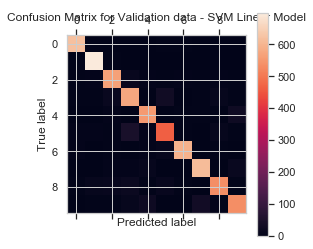

In [30]:
cm = confusion_matrix(y_test,y_pred_1)
plt_cm(cm,'Confusion Matrix for Validation data - SVM Linear Model')

In [31]:
# Buiild non-linear model, using rbf kernel, C=1, default value of gamma

# Create Non Linear Model
non_linear_model = SVC(kernel='rbf',C=1)

# fit the train and test
non_linear_model.fit(X_train, y_train)

# predict the target
y_pred_2 = non_linear_model.predict(X_test)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [105]:
display_metrics(y_test,y_pred_2,"SVM RBF Model")

Accuracy and Metrics Report - SVM RBF Model
SVM RBF Model - Accuracy of Classifier on Validation Images: 0.9511111111111111


Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.97      0.98       630
          1       0.97      0.99      0.98       706
          2       0.89      0.95      0.92       624
          3       0.94      0.93      0.93       652
          4       0.94      0.97      0.96       602
          5       0.95      0.94      0.94       560
          6       0.97      0.97      0.97       629
          7       0.95      0.93      0.94       661
          8       0.96      0.93      0.94       614
          9       0.94      0.93      0.94       622

avg / total       0.95      0.95      0.95      6300



Confusion Matrix:
[[614   0   9   0   3   1   3   0   0   0]
 [  0 697   4   0   3   1   0   0   1   0]
 [  1   3 594   3   6   0   5   4   7   1]
 [  1   4  18 604   1   7   1   6   7   3]
 [  0   0   4   0 58

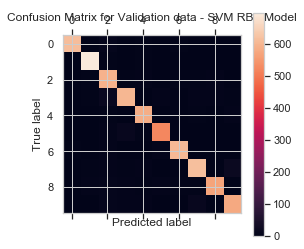

In [106]:
cm2 = confusion_matrix(y_test,y_pred_2)
plt_cm(cm2,'Confusion Matrix for Validation data - SVM RBF Model')

#### **Observation**<br>
>- We have built basic Models using Kernals -`Linear` and `RBF` with default hyper parameters.
>- It has been observed the RBF kernel has higher accuracy score of `0.94` while the linear model has `0.92`<br> 
>- The precision/recall/f1-score are high in both the cases are approximately above average of `92%` and `94%` respectively <br>

#### **Inferences**<br>
>- `RBF` has produced more accuracy score. compromising the model being more complex and low bias (as it tends become overfit)
>- So, we will first try with Kernal `poly` , so that our model being simpler and less over fitting.
>- we will use GridSearchCV with 5 fold cross validation, for hyper parameters  `C` and `gamma` to arrive at an optimal values.

## STEP 4.3: Build Grid Search to Find Optimal Hyperparameters
>- We will  use the RBF kernel to find the optimal C and gamma.

In [107]:
# serialize best estimator of gridsearchcsv
from sklearn.externals import joblib

# creating a KFold object with 3 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters and Set the parameters by cross-validation

hyper_params = [ {'gamma': [10,1,0.1,0.01],
                        'C': [0.001,0.1,100,10e5]}]

# specify model
model = SVC(kernel="poly")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        n_jobs =3,
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

#dump the best estimator (model) in a pickle file.
joblib.dump(model_cv, './finalized_model2.mdl')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 88.2min
[Parallel(n_jobs=3)]: Done  80 out of  80 | elapsed: 128.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid=[{'gamma': [10, 1, 0.1, 0.01], 'C': [0.001, 0.1, 100, 1000000.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

['./finalized_model.mdl']

In [119]:
# load the model from disk
filename='./finalized_model.mdl'
model_cv = joblib.load(filename)

In [120]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,96.137343,0.601859,18.493374,0.224799,0.001,10,"{'C': 0.001, 'gamma': 10}",0.962925,0.968707,0.953741,0.966327,0.963946,0.963129,0.005102,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,97.153548,1.541903,18.350129,0.140384,0.001,1,"{'C': 0.001, 'gamma': 1}",0.962925,0.968707,0.953741,0.966327,0.963946,0.963129,0.005102,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,102.488229,1.970474,21.194591,2.488429,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.962925,0.968707,0.953741,0.966327,0.963946,0.963129,0.005102,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,255.272475,5.891120,37.931021,1.254959,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.826531,0.838095,0.827211,0.833673,0.829252,0.830952,0.004356,16,0.870238,0.865136,0.863265,0.867942,0.862755,0.865867,0.002843
4,117.977027,1.815485,24.286761,0.754675,0.1,10,"{'C': 0.1, 'gamma': 10}",0.962925,0.968707,0.953741,0.966327,0.963946,0.963129,0.005102,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,100.822374,1.564475,19.262070,0.334804,0.1,1,"{'C': 0.1, 'gamma': 1}",0.962925,0.968707,0.953741,0.966327,0.963946,0.963129,0.005102,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,99.673825,0.913871,19.169830,0.289233,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.962925,0.968707,0.953741,0.966327,0.963946,0.963129,0.005102,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,99.791383,0.829442,18.852370,0.246588,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.963265,0.968707,0.953401,0.966327,0.963946,0.963129,0.005228,1,0.999915,0.999915,0.999915,0.999915,0.999830,0.999898,0.000034
8,99.976980,0.940945,19.110591,0.257111,100,10,"{'C': 100, 'gamma': 10}",0.962925,0.968707,0.953741,0.966327,0.963946,0.963129,0.005102,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,100.574065,1.747353,20.931611,2.368313,100,1,"{'C': 100, 'gamma': 1}",0.962925,0.968707,0.953741,0.966327,0.963946,0.963129,0.005102,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [122]:
# Verify the best scores and hyper parameters.
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9631292517006803 corresponding to hyperparameters {'C': 0.001, 'gamma': 10}


### 5.2: Build Model for Best Scores and hyper parameters

In [123]:
# model
model_final = SVC(C=0.001, gamma=10, kernel="poly")

model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_test)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [124]:
display_metrics(y_test,y_pred,"CV Final Model")

Accuracy and Metrics Report - CV Final Model
CV Final Model - Accuracy of Classifier on Validation Images: 0.9712698412698413


Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       630
          1       0.99      0.99      0.99       706
          2       0.96      0.96      0.96       624
          3       0.98      0.96      0.97       652
          4       0.94      0.99      0.96       602
          5       0.97      0.96      0.97       560
          6       0.99      0.97      0.98       629
          7       0.97      0.96      0.97       661
          8       0.95      0.97      0.96       614
          9       0.96      0.95      0.96       622

avg / total       0.97      0.97      0.97      6300



Confusion Matrix:
[[621   0   3   0   3   0   3   0   0   0]
 [  0 701   2   0   3   0   0   0   0   0]
 [  1   1 602   1   6   0   1   2   9   1]
 [  2   1   5 626   2   4   0   3   6   3]
 [  0   0   2   0 

In [125]:
print(y_pred[100:105])
print(y_test[100:105])

print(y_pred[1:10])
print(y_test[1:10])

[5 9 9 5 8]
24076    5
32154    9
32629    9
36725    5
8919     8
Name: label, dtype: int64
[5 6 3 4 3 4 4 4 7]
31455    5
22353    6
14703    3
32278    4
9568     3
36076    4
29310    4
24824    0
11398    7
Name: label, dtype: int64


In [26]:
#for i in (np.random.randint(0,270,5)):
#    two_d = (np.reshape(X_test[i], (28, 28)) * 255).astype(np.uint8)
#    plt.title('predicted label: {0}'. format(y_pred[i]))
#    plt.imshow(two_d, interpolation='nearest', cmap='jet')
#    plt.show();

#### **Observation**<br>
>- Using GridSarchCV with 5 folds cross validation ;
 - The kernal of `Poly`, gives the best CV test accuracy score of `0.9406462585034013` using optimum hyperparameters of C=0.001 and gamma=10.<br>
>- The model re-run (for the same optimum scores and hyper parameters) with standalone train and test data set. We have achived the very decent accuracy score of `0.9507936507936507`.<br>
>- Also,the precision/recall/f1-score all have above 90% accuracy.<br>
>- While analysing the predicted digits with test data, the digits are matched more or less with good accuracy. 
>- We also, plotted the digits to confirm our predictions.<br>

#### **Inferences**<br>
>- We could able to achive pretty decent accuracy score of 95% when we use slightly higher complex model (poly) with respect to a linear model.<br>
>- Now we will use the test data to predict using the same model.<br>

## Step 5 : Model Evaluation 
>- We have test data but without digit label
>- we will use the same final model to predict the 20% of given test data (`5600` rows)
>- We will plot the images to visualize to see our predictions are correct.

## STEP 5.1: Feature Scaling - Test data

In [128]:
test.shape

(14000, 784)

In [129]:
#scaler = StandardScaler()
#X = scaler.fit_transform(test)

In [130]:
scaler = StandardScaler()
X_test_test = scaler.fit_transform(test)

In [131]:
y_test_pred = model_final.predict(X_test_test)

Text(0.5, 1.0, 'predicted label: 9')

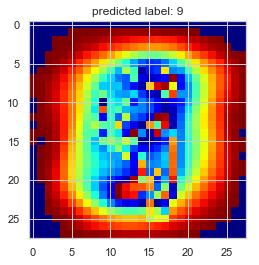

Text(0.5, 1.0, 'predicted label: 4')

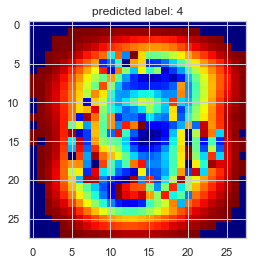

Text(0.5, 1.0, 'predicted label: 7')

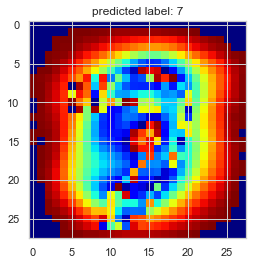

Text(0.5, 1.0, 'predicted label: 5')

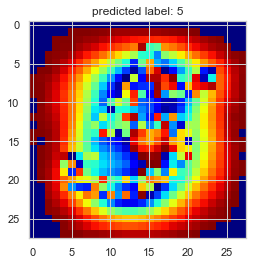

Text(0.5, 1.0, 'predicted label: 2')

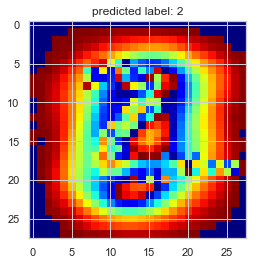

In [132]:
for i in (np.random.randint(0,270,5)):
    two_d = (np.reshape(X_test_test[i], (28, 28)) * 255).astype(np.uint8)
    plt.title('predicted label: {0}'. format(y_test_pred[i]))
    plt.imshow(two_d, interpolation='nearest', cmap='jet')
    plt.show();

## Step 6 : Final Submission of Image Data in csv format.

In [134]:
submission = pd.Series(y_test_pred,name='label')

In [135]:
submission = pd.concat([pd.Series(range(1,14001),name='ImageId'),submission],axis=1)

In [136]:
submission.head()

,ImageId,label
0,1,5
1,2,4
2,3,9
3,4,4
4,5,3


In [137]:
# submit the predicted label to upload in Kaggle.
submission.to_csv("final_submission_v1.csv",index=False)

#### **Observation**<br>
>- While using limited unknown `14000` test data we could able to predict the digits with high accuracy as we can see from the images.
>- ***So we will conclude our final model (model_final) with kernal `Poly` gives the best accuracy score of `0.9631292517006803` having optimum hyperparameters of `C=0.001`  and  `gamma=10`***.<br>